# Assignment 3:  ridge regression

Due date:  Friday 10/5 at 11:59pm


#### Prashant K Thakur

## Preliminaries 

In this assignment you will explore ridge regression applied to the task of predicting wine quality.
You will use the [wine quality](http://archive.ics.uci.edu/ml/datasets/Wine+Quality)
dataset from the UCI machine learning repository, and compare accuracy obtained using ridge regression to the results from a [recent publication](http://www.sciencedirect.com/science/article/pii/S0167923609001377#).
If you have trouble accessing that version of the paper, here's a link to a [preprint](http://www3.dsi.uminho.pt/pcortez/wine5.pdf).
The wine data is composed of two datasets - one for white wines, and one for red wines.  In this assignment perform all your analyses on just the red wine data.

The features for the wine dataset are not standardized, so make sure you do this, especially since we are going to consider the magnitude of the weight vector (recall that standardization entails subtracting the mean and then dividing by the standard deviation for each feature; you can use  Numpy/scikit-learn to perform this computation.


## Part 1

Implement ridge regression in a class called RidgeRegression that implements the classifier API, i.e. ``fit`` and ``predict`` methods with the same signature as the classifiers you implemented in the previous assignment.  Also implement functions for computing the following measures of error:

  * The Root Mean Square Error (RMSE).
  * The Maximum Absolute Deviation (MAD).

For a hypothesis $h$, they are defined as follows:

$$RMSE(h) = \sqrt{\frac{1}{N}\sum_{i=1}^N (y_i - h(\mathbf{x}_i))^2}$$

and

$$MAD(h) = \frac{1}{N}\sum_{i=1}^N |y_i - h(\mathbf{x}_i)|.$$

With the code you just implemented, your next task is to explore the dependence of validation-set error on the value of the regularization parameter, $\lambda$.
In what follows set aside 30% of the data for validation, and compute the in-sample error, and the validation-set error as a function of the parameter $\lambda$ on the red wine data.  Choose the values of $\lambda$ on a logarithmic scale with values 0.01, 0.1, 1, 10, 100, 1000 and plot the RMSE.
Repeat the same experiment where instead of using all the training data, choose 20 random examples out of the training set, and train your model using those 20 examples, while evaluating on the same validation set.

Now answer the following:

  * What is the optimal value of $\lambda$?
  * What observations can you make on the basis of these plots?  (The concepts of overfitting/underfitting should be addressed in your answer).
  * Finally, compare the results that you are getting with the published results in the paper linked above.  In particular, is the performance you have obtained comparable to that observed in the paper?  Please note that for a completely fair comparison, the comparison needs to be made on a separate test set, in the same way the experiment was performed in the paper.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
%matplotlib inline

# Class RidgeRegression
class RidgeRegression:
    
    def __init__(self,lamb=0.0):
        self.lamda = lamb
        
    def name(self,):
        return "RidgeRegression"
    
    def fit(self,X,y):
        X = np.hstack((np.ones((X.shape[0],1)),X))
        I = self.lamda*np.eye(X.shape[1]) # Create identity matrix
        I[0,0] = 0 # No change for the bias term as the model might underfit if bias term is regularized.
        self.w = np.linalg.inv(X.T@X + I)@(X.T@y)


    
    def predict(self,X):
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        return np.inner(self.w, X)
    
    def rmse_mad_error(self,X,y,verbose=False):
        X = np.hstack((np.ones((X.shape[0],1)),X))
        predict = np.inner(self.w,X)
        if verbose:
            return np.sqrt(((y-predict)**2).mean()), (np.abs(y-predict)).mean(), (y-predict)**2, np.abs(y-predict)
        else:
            return np.sqrt(((y-predict)**2).mean()), (np.abs(y-predict)).mean() 


def wine_loader():
#     df = pd.read_csv('winequality-red.csv',delimiter=";")
    X = np.genfromtxt("winequality-red.csv",delimiter=';',usecols=range(11),skip_header=1)
    y = np.genfromtxt("winequality-red.csv",delimiter=';',usecols=[11],skip_header=1)
    return X,y

def standardize(X):
    means = X.mean(axis=0)
    stds = X.std(axis=0)
    return (X - means) / stds

def partition_data(X,y,test_split=0.3):
    from sklearn.model_selection import train_test_split
    X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=test_split)
    return X_train, y_train, X_val, y_val

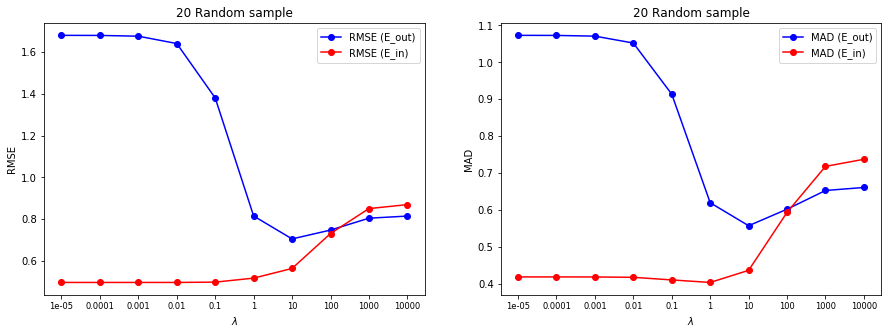

In [2]:
def lambda_test(Xtrain,y_train, Xval, y_val,fig_label=''):
    lambdas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
    rmse_in = []
    mad_in = []
    rmse_out = []
    mad_out = []
    for i in lambdas:
        model = RidgeRegression(i)
        model.fit(Xtrain, y_train)

        rmse, mad = model.rmse_mad_error(Xtrain,y_train)
        rmse_in.append(rmse)
        mad_in.append(mad)
        rmse_o, mad_o = model.rmse_mad_error(Xval, y_val)
        rmse_out.append(rmse_o)
        mad_out.append(mad_o)
        del model
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(rmse_out,'bo-', label="RMSE (E_out)")
    plt.plot(rmse_in, 'ro-', label="RMSE (E_in)")
    plt.xticks(range(len(lambdas)), lambdas, size='small')
#     plt.text(1,2.5, "RMSE: Minimum value:%.3f at $\lambda$:%s"%(min(rmse_out),lambdas[rmse_out.index(min(rmse_out))]))
#     plt.text(1,2, "MAD: Minimum value:%.3f at $\lambda$:%s"%(min(mad_out),lambdas[mad_out.index(min(mad_out))]))

    plt.xlabel("$\lambda$")
    plt.ylabel("RMSE")
    plt.title(fig_label)
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(mad_out,'bo-', label="MAD (E_out)")
    plt.plot(mad_in, 'ro-', label="MAD (E_in)")
    plt.xticks(range(len(lambdas)), lambdas, size='small')
    plt.xlabel("$\lambda$")
    plt.ylabel("MAD")
    plt.title(fig_label)
#     plt.text(1,2.5, "RMSE: Minimum value:%.3f at $\lambda$:%s"%(min(rmse_in),lambdas[rmse_in.index(min(rmse_in))]))
#     plt.text(1,2, "MAD: Minimum value:%.3f at $\lambda$:%s"%(min(mad_in),lambdas[mad_in.index(min(mad_in))]))
    plt.legend()
#     print(sorted(mad_out))


X,y = wine_loader()
X = standardize(X)
Xtrain, y_train, Xval, y_val = partition_data(X,y,test_split=0.3)
lambda_test(Xtrain, y_train, Xval, y_val,fig_label="Training:validation = 70:30")
idx = np.random.choice(range(len(Xtrain)),20,replace=False)
# print(idx)
Xrand, y_rand = Xtrain[idx], y_train[idx]
lambda_test(Xrand, y_rand, Xval, y_val,fig_label="20 Random sample")

### Answer:
#### a) What is the optimal value of $\lambda$?

=> In order to select an optimal value of lambda the graph of out-sample error(RMSE/MAD) on "20 Random sample" was used, the optimal value of lambda was found to be 10. The value of lambda fluctuates for different runs. After running for multiple times, it was found that 10 occurs most of the time so this value was choosen. If 70:30 (training:validation) dataset is used, the value at 10 and 100 are similar with other lower $\lambda$. So to make a generalized optimized value, 10 was selected.

#### b) What observations can you make on the basis of these plots?  (The concepts of overfitting/underfitting should be addressed in your answer)

=> As the value of lambda increases, the corresponding value of weight vector decreases because of the regularization effect. For instance, when we increase the lambda value from 0.0001 to 10000, we can see there is noticable change in weight vector(for one of the run) while using 20 random sampling for training. 

    lambda = 0.0001
    weight vector = [ 5.8724908   2.92071525 -0.6572583  -0.24482596  1.15972988  1.92811759 -0.10028257 -0.49500151 
    -3.13296437  0.04186446  0.22972807 -1.27840857]

    lambda = 10000
    weight vector = [ 0.01106678 -0.00287703 -0.0024643  -0.00135324  0.00146866 -0.00096239 -0.00327758 -0.00483342 
    -0.00045543  0.00047636 -0.00282866 -0.0005573]
    
With the increase in value of lambda, the model underfits as the weight vector is small and there would be problem to accurately capture the importance of features for given dataset. Similarly, when the lambda is very less, the model was trying to overfit and the regularization has very little effect on the learning and the model is trying to learn unnecessary noises or random fluctuation of features. 

As we see in figure "20 Random sample" the out-sample error (E_out for RMSE) is higher than in-sample error(RMSE E_in) because of the overfitting for lower value of lambda and after certain value the error against increases because of underfitting (for higher value of lambda).

#### c) Finally, compare the results that you are getting with the published results in the paper linked above.  In particular, is the performance you have obtained comparable to that observed in the paper?  Please note that for a completely fair comparison, the comparison needs to be made on a separate test set, in the same way the experiment was performed in the paper.}

=> The MAD for MR in the paper has been reported as 0.5 $\pm$ 0.00 for 2/3 (~67% training set) and 1/3 (~33% test set). For this experiment, we have to compute 70% training set and 30% validation set which is similar to the paper data partition. Also the MAD error for the Ridge Regression is given by 0.512 (in most of the cases) so we can say the error for the validation set (or out-sample Error) is comparable to the experiments conducted in the paper. 

    MAD (Out-sample Error) : [0.5120585463261843, 0.512058547756608, 0.5120585620610533, 0.5120587051264188, 0.5120601378676642,
    0.5120746704929172, 0.5122401001307313, 0.5154844556570182, 0.5562951239779643, 0.6619066870989925]
    
Note: The performance can also be measured in terms of confusion matrix or accuracy with given threshold but there was some suggestion from Professor to not do any extra work for the comparison, therefore the MAD value is used as a reference for the comparison. 

## Part 2:  regression error characteristic curves

Regression Error Characteristic (REC) curves are an interesting way of visualizing regression error as described
in the following [paper](http://machinelearning.wustl.edu/mlpapers/paper_files/icml2003_BiB03.pdf).
Write a function that plots the REC curve of a regression method, and plot the REC curve of the best regressor you found in Part 1 of the assignment (i.e. the one that gave the lowest error on the validation set).  Plot the REC curve for both the validation set and the training set.
What can you learn from this curve that you cannot learn from an error measure such as RMSE or MAD?



In [39]:
def REC(error_list):
    e_prev=0
    correct=0
    prev_errors = []
    y_axis = []
    for val in error_list:
        if val > e_prev :
            prev_errors = np.append(prev_errors,e_prev)
            y_axis =np.append(y_axis,correct/len(error_list))
            e_prev=val
        correct += 1

    return prev_errors,y_axis

# Best lambda = 10 from part-2
X,y = wine_loader()
X = standardize(X)
Xtrain, y_train, Xval, y_val = partition_data(X,y,test_split=0.3)
model = RidgeRegression(10)
model.fit(Xtrain, y_train)
# rmse_mad_error with verbose option would return row wise errors and overall errors.
error_insample = model.rmse_mad_error(Xtrain, y_train,verbose=True)
error_outsample = model.rmse_mad_error(Xval, y_val,verbose=True)
# error_sample has [overall_rmse, overall_mad, rowwise_rmse, rowwise_mad]
# Get RMSE for in-sample Error
rmse_x,rmse_y = REC(sorted(error_insample[2]))
# Get MAD for in-sample Error
mad_x,mad_y = REC(sorted(error_insample[3]))
# Get outsample RMSE
vrmse_x,vrmse_y = REC(sorted(error_outsample[2]))
# Get outsample MAD
vmad_x,vmad_y = REC(sorted(error_outsample[3]))

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(7)
fig.set_figwidth(15)
ax0,ax1 = axes.flatten()
ax0.plot(rmse_x,rmse_y,'b-',label="RidgeRegression (training)")
ax0.set_title("REC for RMSE")
ax0.set_xlabel("Square Residual")
ax0.set_ylabel("Cummulative Accuracy")
ax0.plot(vrmse_x,vrmse_y,'-r',label="RidgeRegression (Validation)")
ax1.plot(mad_x,mad_y,'b-',label="RidgeRegression (training)")
ax1.set_title("REC for MAD Error")
ax1.plot(vmad_x,vmad_y,'r-', label="RidgeRegression (validation)")
ax1.set_xlabel("Absolute Deviation")
ax1.set_ylabel("Cummulative Accuracy")
ax0.legend()
ax1.legend();


#### Answer:

The REC curve gives us an additional information about the measure of expected error for the regression model via area above the REC curve which can't be deduced from RMES/MAD alone. So the minimum the area above the curve, the better as the error is minimized. This helps to separate different algorithms performance easily (an ideal regression algorithm would reach 1 (on y-axis) as quickly as possible). Therefore, the model is better if they achieve the plateau region within lower tolerance. From the graph above for RMSE we can see that the tolerance of 1 includes most of the data points and at around 2 almost all the data are included as we see minor change in the vertical axis. The variation in the error for both training and validation set is similar that is why both the curve are similar (i.e. all the data points are included within similar tolerance range). 

We also get the total number ($\underline{cummulative}$) correct classification for given tolerance which is not available in general RMSE/MAD plot (as they only give the error for some iteration or other parameter under consideration). The RMSE/MAD error plot doesn't give any information about the overall data nature like REC. 

## Part 3:  weight vector analysis

As we discussed in class, the magnitude of the weight vector can be interpreted as a measure of feature importance.
Train a ridge regression classifier on a subset of the dataset that you reserved for training.
We will explore the relationship between the magnitude of weight vector components and their relevance to the classification task in several ways.
Each feature is associated with a component of the weight vector.  It can also be associated with the correlation of that feature with the vector of labels.
As we discussed in class, the magnitude of the weight vector can give an indication of feature relevance; another measure of relevance of a feature is its correlation with the labels.  To compare the two, 
create a scatter plot of weight vector components against the [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient) of the corresponding feature with the labels (again, you can use Numpy to compute it).
What can you conclude from this plot?
The paper ranks features according to their importance using a different approach.  Compare your results with what they obtain.

Next, perform the following experiment:
Incrementally remove the feature with the lowest absolute value of the weight vector and retrain the ridge regression classifier.
Plot RMSE as a function of the number of features that remain on the test set which you have set aside and comment on the results.


In [54]:
# Test code to check the relationship between individual features with one another using seaborn.

# import seaborn as sb
# from matplotlib import pylab
# from pylab import rcParams
# rcParams['figure.figsize']=5,4
# sb.set_style('whitegrid')
# # sb.pairplot(df)

# from operator import itemgetter
# df = pd.DataFrame({'Weight vector component':list(model.w[1:]),'Pearson Correlation Coefficient':list(data_corr)[:-1],'label':list(df_wine)[:-1]})
# sns.lmplot(data=df, x="Weight vector component", y="Pearson Correlation Coefficient", hue='label', fit_reg=False, legend=True, legend_out=True,palette=sns.color_palette("muted"),height=7);


In [24]:
# Read data into pandas dataframe.
df_wine = pd.read_csv('winequality-red.csv',delimiter=";")
X,y = wine_loader()
X = standardize(X)
Xtrain, y_train, Xval, y_val = partition_data(X,y,test_split=0.3)
model=RidgeRegression(1)
model.fit(Xtrain,y_train)
df_corr=df_wine.corr()
data_corr = df_corr["quality"]
# df_corr

val=list(zip(list(df_wine)[:-1],list(model.w[1:]),list(data_corr)[:-1]))
# Sort based on weight absolute value.
val.sort(key=lambda v: abs(v[1]),reverse=True)
plt.figure(figsize=(10,10))
for i in val:
    plt.plot(i[1],i[2],'o',label=i[0])
plt.title("Weight vector Components Vs Pearson Correlation Coefficient")
plt.xlabel("Weight vector components")
plt.ylabel("Pearson Correlation Coefficient")
plt.legend(loc="lower right");

#### Answer:

The above figure which plots the weight vector components (w value) against Pearson's Correlation coefficient. The points are tentatively arranged in linear fashion so we can say there is some linear relationship between these two variables (with some deviation). But if we fit a line to the points in the above figure then we would get a straight line which suggests that as the value of Pearson's correlation coefficient increases, the weight vector component also increases. Also for weight vector component near zero, there are points which has Pearson's Correlation Coefficient near to zero. Thus, we can say that the weight vector components are updated based on the importance of feature for the given dataset.

In [42]:
print("   Feature\t\t   Weight Vector Components\tPearson's Correlation Coefficient")
print("----------------------------------------------------------------------------------------")
for idx, i in enumerate(val):
    print("{:<4}{:25}{:>10.5f}{:>30.5f}".format(idx+1,i[0],float(i[1]),float(i[2])))

   Feature		   Weight Vector Components	Pearson's Correlation Coefficient
----------------------------------------------------------------------------------------
1   alcohol                     0.30683                       0.47617
2   volatile acidity           -0.18031                      -0.39056
3   sulphates                   0.15144                       0.25140
4   total sulfur dioxide       -0.09138                      -0.18510
5   chlorides                  -0.08874                      -0.12891
6   pH                         -0.08709                      -0.05773
7   fixed acidity               0.05405                       0.12405
8   density                    -0.05047                      -0.17492
9   free sulfur dioxide         0.04566                      -0.05066
10  citric acid                -0.03652                       0.22637
11  residual sugar              0.03093                       0.01373


#### Answer: 


The chart above shows the top most feature based on the weight vector components. The items in the table are arranged based on descending order of absolute value of the weight vector. As the table suggests, "alcohol" seems to have higher correlation with the quality(label) and has higher value for corresponding weight vector. In this particular run(training/testing of model), the residual sugar seems to be the least important feature, however this changes for some runs and it also changes with different lambda values. Similarly, if the correlation is lower (i.e. absolute value closer to 0) then the weight vector for that feature is also smaller as seen in above case for "residual sugar". From the figure we can see that when the weight vector for any feature is near to zero then the Pearson's Correlation coefficient is also near to zero. 

The chart in the table has different features priority selection for SVM but that information doesn't seem to match much with the RidgeRegression model. In some run the least important feature matches to "critical acid" as discussed in the paper. However, we can see for several runs the weight for sulphates is greater than total sulfur dioxide which seems to be consistent with the paper where sulphates has higher percedence over total sulfur dioxide. Similar relations also match with some other features pair.

Remark: The data changes for different runs but above information is consistent for most of the runs.

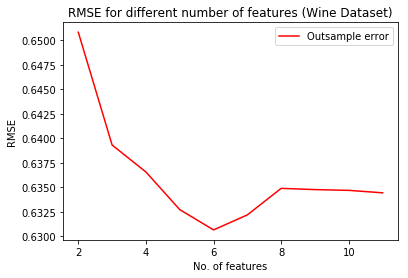

In [33]:
def remove_features():
    X,y = wine_loader()
    X = standardize(X)
    
    Xtrain, y_train, Xval, y_val = partition_data(X,y,test_split=0.3)
    model = RidgeRegression(10)
    
    rmse_errors = []
    num_features = []
    for i in range(10) :
        model.fit(Xtrain,y_train)
        rmse, mad = model.rmse_mad_error(Xval,y_val)
        rmse_errors=np.append(rmse_errors,rmse)
        min_index=np.argmin(np.abs(model.w[1:]))
        Xtrain = np.delete(Xtrain,min_index,1)
        Xval = np.delete(Xval,min_index,1)
        num_features = np.append(num_features, (11-i))

    plt.figure()
    plt.plot(num_features, rmse_errors, 'r-',label="Outsample error")
    plt.xlabel("No. of features")
    plt.ylabel("RMSE")
    plt.title("RMSE for different number of features (Wine Dataset)")
    plt.legend()
    
remove_features()

#### Answer:
As we can see in the above graph as the number of features decreases, the root mean square error for validation set increases. Similarly, if the number of features is higher than there is still higher error. While analyzing the graph we can see the minimum error is when number of features are slightly fewer than 11 (total number of features). This means the Ridge Regression works better when certain features are removed from the dataset. Please note, the graph changes for different runs but the nature of the graph remains same (i.e. the number of features between 4-8 gives less RMSE). We can explain this by stating that as the number of features increases the model suffers overfitting so it starts to perform worse on the validation dataset. Similarly, when the number of features is very low, the model is not able to find a generalized way to classify the new data it has never seen. Since the number of features are very important to give the model information to use to perform the classification or other task. If we give very less information it also affects the learning process negatively. Therefore, we have to find the optimal value of features for our model and there are several ways for feature selection like crossvalidation, regularization etc. 

### Submission

Submit your report as a Jupyter notebook via Canvas.  Running the notebook should generate all the plots and results in your notebook.


### Grading 

Here is what the grade sheet will look like for this assignment.  A few general guidelines for this and future assignments in the course:

  * Your answers should be concise and to the point.  We will take off points if that is not the case.
  * Always provide a description of the method you used to produce a given result in sufficient detail such that the reader can reproduce your results on the basis of the description.  You can use a few lines of python code or pseudo-code.


Grading sheet for the assignment:

```
Part 1:  50 points.
(15 points):  Ridge regression is correctly implemented.
(15 points):  Plots of RMSE as a function of lambda are generated correctly.
(20 points):  Discussion of the results

Part 2:  25 points.
(15 points):  REC curves are generated correctly
(10 points):  discussion of REC curves

Part 3:  25 points.
(20 points):  Weight vector analysis
( 5 points):  Comparison to the published results
```


Grading will be based on the following criteria:

  * Correctness of answers to math problems
  * Math is formatted as LaTex equations
  * Correct behavior of the required code
  * Easy to understand plots 
  * Overall readability and organization of the notebook
  * Effort in making interesting observations where requested.
  * Conciseness.  Points may be taken off if the notebook is overly 
  